In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV, JSON file I/O (e.g. pd.read_csv)

In [3]:
from google.colab import drive # google drivekin konektatzeko

drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
fake = pd.read_csv('/content/drive/MyDrive/ColabFile/Fake.csv')
real = pd.read_csv('/content/drive/MyDrive/ColabFile/True.csv')

print("fake luzeera")
print(len(fake))
print("real luzeera")
print(len(real))

fake luzeera
23481
real luzeera
21417


In [5]:
fake['label'] = 0
real['label'] = 1

hasiera_data = real.append(fake)

labelak = hasiera_data['label']

hasiera_data

,title,text,subject,date,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1
...,...,...,...,...,...
23476,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016",0
23477,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016",0
23478,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016",0
23479,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016",0


## Testua preprozezatu

In [6]:
from nltk.corpus import stopwords
from gensim.models.doc2vec import LabeledSentence
from gensim import utils
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from gensim.utils import simple_preprocess
import string

def constructLabeledSentences(data):
    sentences=[]
    for index, row in data.iteritems():
        sentences.append(LabeledSentence(utils.to_unicode(row).split(), ['Text' + '_%s' % str(index)]))
    return sentences

def textClean(text):
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = text.lower().split()
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops]    
    text = " ".join(text)
    return(text)
    
def cleanup(text):
    text = textClean(text)
    text= text.translate(str.maketrans("","", string.punctuation))
    return text

allText = hasiera_data['text'].apply(cleanup)
sentences = constructLabeledSentences(allText)
allText.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated `LabeledSentence` (Class will be removed in 4.0.0, use TaggedDocument instead).
  


0    washington reuters  head conservative republic...
1    washington reuters  transgender people allowed...
2    washington reuters  special counsel investigat...
3    washington reuters  trump campaign adviser geo...
4    seattlewashington reuters  president donald tr...
Name: text, dtype: object

## Doc2Vec

In [8]:
from gensim.models import Doc2Vec
import os

Text_INPUT_DIM=300


text_model=None
filename='/content/drive/MyDrive/ColabFile/docEmbeddings_5_clean.d2v'
if os.path.isfile(filename):
    text_model = Doc2Vec.load(filename)
else:
    text_model = Doc2Vec(min_count=1, window=5, size=Text_INPUT_DIM, sample=1e-4, negative=5, workers=4, iter=5,seed=1)
    text_model.build_vocab(sentences)
    text_model.train(sentences, total_examples=text_model.corpus_count, epochs=text_model.iter)
    text_model.save(filename)

/usr/local/lib/python3.7/dist-packages/gensim/models/doc2vec.py:566: UserWarning: The parameter `iter` is deprecated, will be removed in 4.0.0, use `epochs` instead.
  warnings.warn("The parameter `iter` is deprecated, will be removed in 4.0.0, use `epochs` instead.")
/usr/local/lib/python3.7/dist-packages/gensim/models/doc2vec.py:570: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  


In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(allText, labelak, train_size=0.75, test_size=0.25, random_state=3)

In [10]:
from keras.preprocessing import text

num_wrd=5000

tokenize = text.Tokenizer(num_words=num_wrd, char_level=False)

tokenize.fit_on_texts(X_train) # only fit on train
X_train_tok = tokenize.texts_to_matrix(X_train)
X_test_tok = tokenize.texts_to_matrix(X_test)

In [11]:
# Inspect the dimenstions of our training and test data (this is helpful to debug)
print('x_train shape:', X_train_tok.shape)
print('x_test shape:', X_test_tok.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

x_train shape: (33673, 5000)
x_test shape: (11225, 5000)
y_train shape: (33673,)
y_test shape: (11225,)


In [12]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout

# Build the model
model = Sequential()
model.add(Dense(1, input_dim=num_wrd, activation='relu'))
model.add(Dropout(0.5))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 5001      
                                                                 
 dropout (Dropout)           (None, 1)                 0         
                                                                 
 activation (Activation)     (None, 1)                 0         
                                                                 
Total params: 5,001
Trainable params: 5,001
Non-trainable params: 0
_________________________________________________________________


In [16]:
history = model.fit(X_train_tok, y_train,
                    batch_size=10,
                    epochs=100,
                    verbose=1,
                    validation_split=0.1)

Epoch 1/100
3031/3031 [==============================] - 6s 2ms/step - loss: 0.5293 - accuracy: 0.7611 - val_loss: 0.3822 - val_accuracy: 0.9911
Epoch 2/100
3031/3031 [==============================] - 6s 2ms/step - loss: 0.5309 - accuracy: 0.7587 - val_loss: 0.3832 - val_accuracy: 0.9908
Epoch 3/100
3031/3031 [==============================] - 6s 2ms/step - loss: 0.5294 - accuracy: 0.7605 - val_loss: 0.3837 - val_accuracy: 0.9893
Epoch 4/100
3031/3031 [==============================] - 6s 2ms/step - loss: 0.5293 - accuracy: 0.7611 - val_loss: 0.3824 - val_accuracy: 0.9905
Epoch 5/100
3031/3031 [==============================] - 6s 2ms/step - loss: 0.5269 - accuracy: 0.7640 - val_loss: 0.3853 - val_accuracy: 0.9884
Epoch 6/100
3031/3031 [==============================] - 6s 2ms/step - loss: 0.5269 - accuracy: 0.7640 - val_loss: 0.3842 - val_accuracy: 0.9896
Epoch 7/100
3031/3031 [==============================] - 6s 2ms/step - loss: 0.5302 - accuracy: 0.7591 - val_loss: 0.3848 - val_ac

In [17]:
score = model.evaluate(X_test_tok, y_test,
                       batch_size=32, verbose=1)
print('Test score:', score[0])
print('Test accuracy:', score[1])

351/351 [==============================] - 1s 2ms/step - loss: 0.5199 - accuracy: 0.9758
Test score: 0.5198875069618225
Test accuracy: 0.9757683873176575


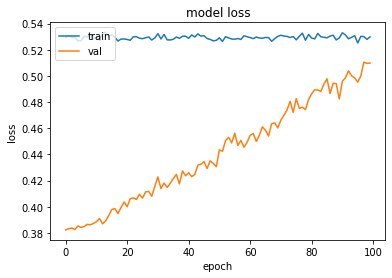

In [18]:
from matplotlib import pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

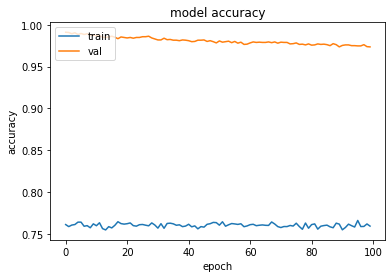

In [19]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# Here's how to generate a prediction on individual examples
text_labels = [1,0]

pred = model.predict(X_test_tok)

In [ ]:
pred_bal = ['fake' if x<=0.5 else 'real' for x in pred]

In [ ]:
y_test_bal = ['fake' if x==0 else 'real' for x in y_test]

In [ ]:
count = pred_bal.count('fake')
print(count)

5792


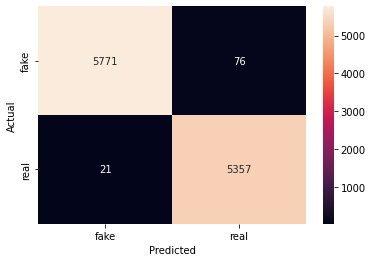

In [ ]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

data = {'y_Actual': y_test_bal,
        'y_Predicted': pred_bal
        }

df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])

sn.heatmap(confusion_matrix, annot=True,fmt='g')
plt.show()